# Unit 3 Project Spark DataFrame API

This is UNIT 3 Final Project.

Read the instructions and answer the questions.



# Setup

Setup spark for running in local mode using these instructions.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz
!tar xf spark-3.1.3-bin-hadoop2.7.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"

In [ ]:
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
# create the Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from pyspark.sql import DataFrame
import time

# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext
spark

# Vietnam War Dataset

**Pres. Johnson**: _What do you think about this Vietnam thing? I’d like to hear you talk a little bit._

**Sen. Russell**: _Well, frankly, Mr. President, it’s the damn worse mess that I ever saw, and I don’t like to brag and I never have been right many times in my life, but I knew that we were going to get into this sort of mess when we went in there._

May 27, 1964

![banner](https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/banner.jpg)

----

The Vietnam War, also known as the Second Indochina War, and in Vietnam as the Resistance War Against America or simply the American War, was a conflict that occurred in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and was officially fought between North Vietnam and the government of South Vietnam.

**The dataset describes all the air force operation in during the Vietnam War.**

**Bombing_Operations** [Get the dataset here](https://courses.compute.dtu.dk/02807/2021/lectures/week8/Bombing_Operations.json.gz)

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Aircraft_Glossary** [Get the dataset here](https://courses.compute.dtu.dk/02807/2021/lectures/week8/Aircraft_Glossary.json.gz)

- AirCraft: _Aircraft model (example: EC-47)_
- AirCraftName
- AirCraftType

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

Load the datasets (this may require a bit of patience).

In [ ]:
df_aircraft = spark.read.json('Aircraft_Glossary.json.gz')

In [ ]:
df_operations = spark.read.json('Bombing_Operations.json.gz')

Display the schemas and inspect some rows of `df_operations`.

In [ ]:
# your code goes here
df_operations.schema

StructType(List(StructField(AirCraft,StringType,true),StructField(ContryFlyingMission,StringType,true),StructField(MissionDate,StringType,true),StructField(OperationSupported,StringType,true),StructField(PeriodOfDay,StringType,true),StructField(TakeoffLocation,StringType,true),StructField(TargetCountry,StringType,true),StructField(TimeOnTarget,DoubleType,true),StructField(WeaponType,StringType,true),StructField(WeaponsLoadedWeight,LongType,true)))

In [ ]:
# your code goes here
df_operations.show(10)
df_aircraft.show(10)

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              null|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                null|                  0|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              null|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                null|                  0|
|    RF-4|UNITED STATES OF ...| 1973-07-28|              null|          D|       UDORN AB|         LAOS|       730.0|                null|                  0|
|     A-1|UNITED STATES OF ...| 1970-02-02|   

How many bombing operations are described in `df_operations`?

In [ ]:
# your code goes here

bomb_op = df_operations.filter(col('WeaponType').isNotNull())
num_bombing_op = bomb_op.count()
print('Number of bombing operations made: ', num_bombing_op)

Number of bombing operations made:  2189036


# Question 1: Which countries are involved and in how many missions?

The country associated with the operation is found in the `ContryFlyingMission` [sic] field. Display the result using `show`.

In [ ]:
# your code goes here
country_missions = df_operations.groupBy('ContryFlyingMission').count()
country_missions.show()

+--------------------+-------+
| ContryFlyingMission|  count|
+--------------------+-------+
|     VIETNAM (SOUTH)| 622013|
|       KOREA (SOUTH)|  24469|
|UNITED STATES OF ...|3708997|
|           AUSTRALIA|  12519|
|                LAOS|  32777|
+--------------------+-------+



Plot a horizontal bar chart with the number of operations by country. Consider using a logarithmic scale due to the skewedness of per country operations.

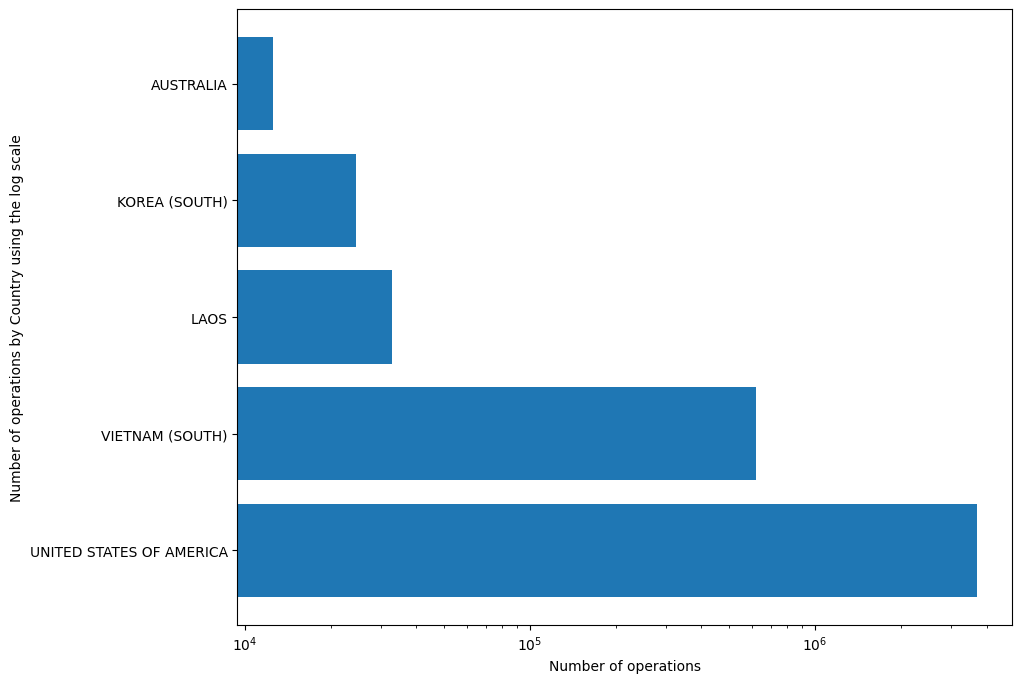

In [ ]:
# your code goes here
country_missions_plot = country_missions.toPandas()
country_missions_plot.sort_values(by='count', ascending=False, inplace=True)

#plot zone
plt.figure(figsize=(10,8))
plt.barh(np.arange(len(country_missions_plot)), country_missions_plot['count'], log=True)
plt.yticks(np.arange(len(country_missions_plot)), country_missions_plot['ContryFlyingMission'])
plt.xlabel('Number of operations')
plt.ylabel('Number of operations by Country using the log scale')
plt.show()

# Question 2: Show the number of missions in time for each of the countries involved.

Transform the dataframe to contain only relevant columns for this query. Observe that `MissionDate` field is of type string. You can use `F.to_date` to convert it to a `DateType`.

In [ ]:
# your code goes here
mission_to_over_time = df_operations.select('ContryFlyingMission', 'MissionDate')
mission_to_over_time = mission_to_over_time.withColumn('MissionDate', F.to_date('MissionDate'))
missions_by_country_date = mission_to_over_time.groupBy('ContryFlyingMission', 'MissionDate').count()
missions_by_country_date.show()

+--------------------+-----------+-----+
| ContryFlyingMission|MissionDate|count|
+--------------------+-----------+-----+
|UNITED STATES OF ...| 1970-04-08| 1983|
|UNITED STATES OF ...| 1973-02-01|  661|
|     VIETNAM (SOUTH)| 1971-09-10|  371|
|UNITED STATES OF ...| 1973-08-01|  559|
|UNITED STATES OF ...| 1970-12-09| 1259|
|UNITED STATES OF ...| 1970-11-11| 1072|
|           AUSTRALIA| 1970-07-23|   26|
|UNITED STATES OF ...| 1971-03-18| 1342|
|UNITED STATES OF ...| 1974-05-20|   63|
|     VIETNAM (SOUTH)| 1973-05-02|  189|
|     VIETNAM (SOUTH)| 1972-10-30|  486|
|       KOREA (SOUTH)| 1973-11-22|   26|
|UNITED STATES OF ...| 1970-01-04| 1730|
|     VIETNAM (SOUTH)| 1971-09-24|  345|
|     VIETNAM (SOUTH)| 1972-03-07|  408|
|     VIETNAM (SOUTH)| 1970-05-05|  216|
|     VIETNAM (SOUTH)| 1972-07-15|  429|
|                LAOS| 1971-01-09|   23|
|           AUSTRALIA| 1971-03-17|   21|
|           AUSTRALIA| 1970-04-21|   24|
+--------------------+-----------+-----+
only showing top

Now compute the count of missions per country for each `MissionDate` and sort the dataframe by date (ascending).

In [ ]:
# your code goes here
mission_to_over_time = df_operations.select('ContryFlyingMission', 'MissionDate')
mission_to_over_time = mission_to_over_time.withColumn('MissionDate', F.to_date('MissionDate'))
missions_by_country_date = mission_to_over_time.groupBy('ContryFlyingMission', 'MissionDate').count()
missions_by_country_date = missions_by_country_date.orderBy('MissionDate')
missions_by_country_date.show()

+--------------------+-----------+-----+
| ContryFlyingMission|MissionDate|count|
+--------------------+-----------+-----+
|UNITED STATES OF ...| 1965-10-01|  447|
|UNITED STATES OF ...| 1965-10-02|  652|
|UNITED STATES OF ...| 1965-10-03|  608|
|UNITED STATES OF ...| 1965-10-04|  532|
|     VIETNAM (SOUTH)| 1965-10-05|   72|
|UNITED STATES OF ...| 1965-10-05|  697|
|UNITED STATES OF ...| 1965-10-06|  689|
|     VIETNAM (SOUTH)| 1965-10-06|   49|
|     VIETNAM (SOUTH)| 1965-10-07|   50|
|UNITED STATES OF ...| 1965-10-07|  605|
|     VIETNAM (SOUTH)| 1965-10-08|   64|
|UNITED STATES OF ...| 1965-10-08|  700|
|UNITED STATES OF ...| 1965-10-09|  677|
|     VIETNAM (SOUTH)| 1965-10-09|   69|
|UNITED STATES OF ...| 1965-10-10|  789|
|     VIETNAM (SOUTH)| 1965-10-10|   59|
|UNITED STATES OF ...| 1965-10-11|  455|
|     VIETNAM (SOUTH)| 1965-10-11|   48|
|     VIETNAM (SOUTH)| 1965-10-12|   62|
|UNITED STATES OF ...| 1965-10-12|  449|
+--------------------+-----------+-----+
only showing top

Now we can plot the content with a different series for each country (using an appropriate plot type). To this end, you may use the pattern from "Slides Week 4" where we did a scatter plot colored by country.

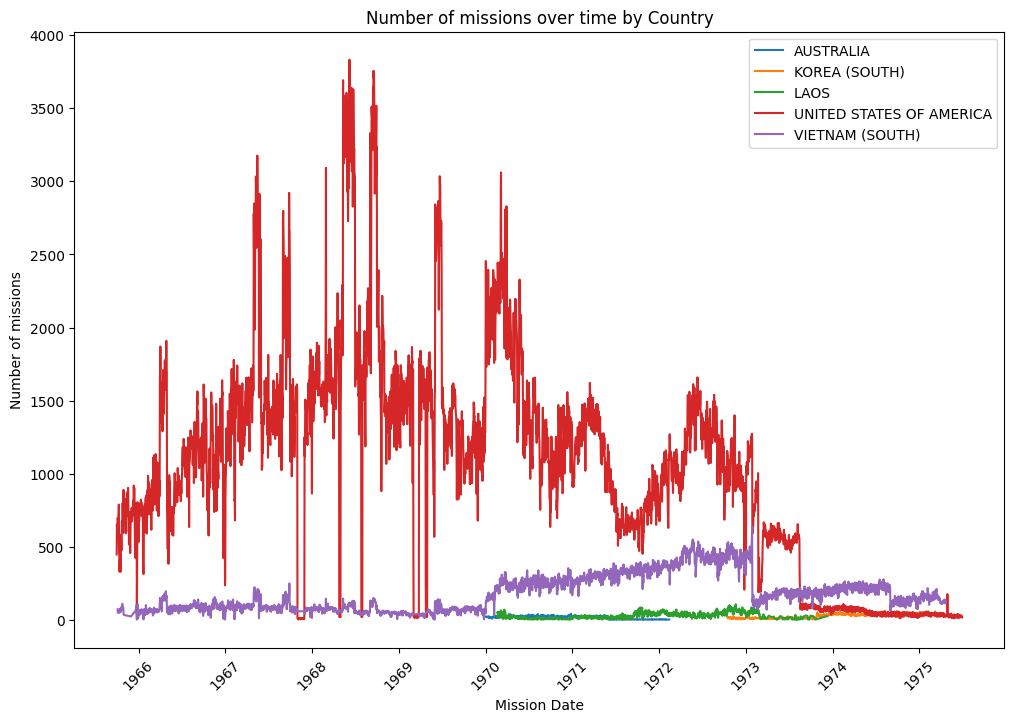

In [ ]:
# your code goes here
missions_by_country_date_transformed = missions_by_country_date.toPandas()

grouped_df = missions_by_country_date_transformed.groupby('ContryFlyingMission')

#Plot zone

plt.figure(figsize=(12,8))

for country, data in grouped_df:
  plt.plot(data['MissionDate'], data['count'], label=country)

plt.xlabel('Mission Date')
plt.ylabel('Number of missions')
plt.title('Number of missions over time by Country')

plt.xticks(rotation=45)
plt.legend()
plt.show()

We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.

The plot looks a bit erratic, as the count is computed for each date. We can alleviate this by instead having the x-axis be months, and the y-axis be the count of operations in that month. Recompute such a dataframe and plot it once more. To this end, `F.trunc` will come in handy.

<ipython-input-34-12be2675fe92>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  missions_by_country_month_df = missions_by_country_date_transformed.groupby(['ContryFlyingMission', 'Month']).sum().reset_index()


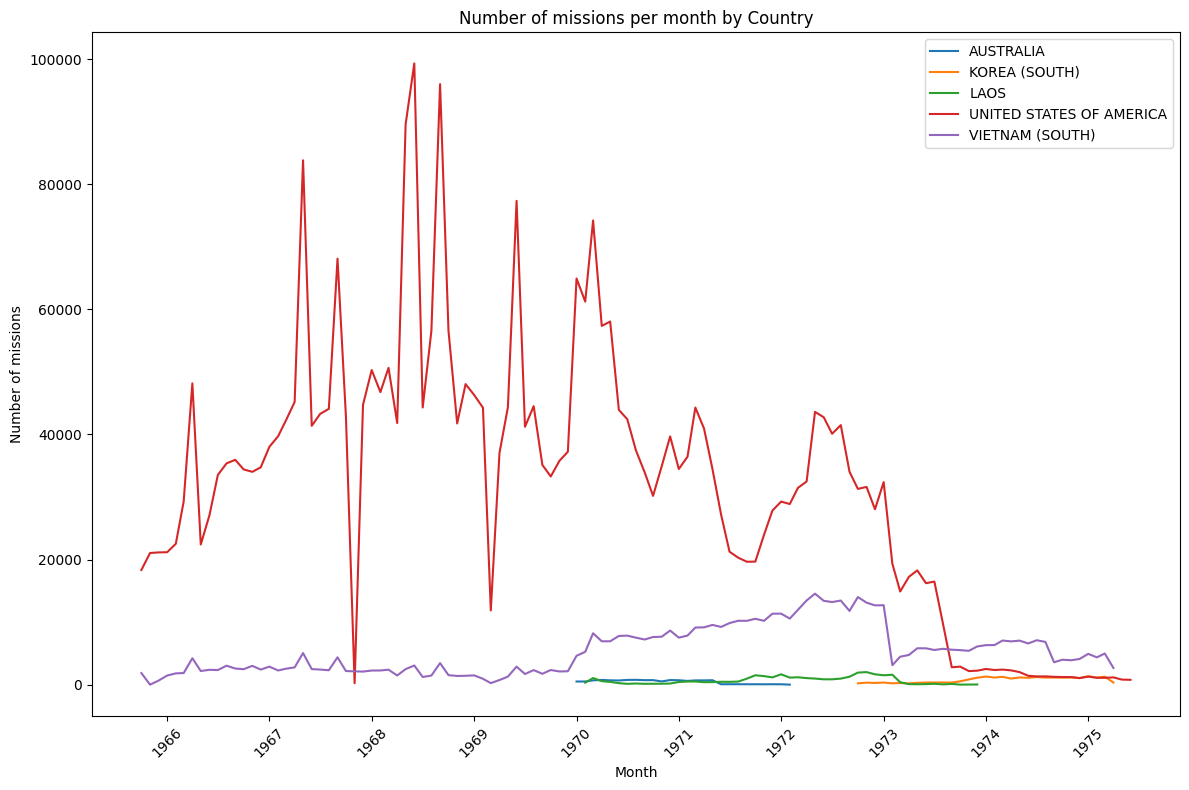

In [ ]:
missions_by_country_date_transformed['MissionDate'] = pd.to_datetime(missions_by_country_date_transformed['MissionDate'])

missions_by_country_date_transformed['Month'] = missions_by_country_date_transformed['MissionDate'].dt.to_period('M')

missions_by_country_month_df = missions_by_country_date_transformed.groupby(['ContryFlyingMission', 'Month']).sum().reset_index()


plt.figure(figsize=(12, 8))

grouped_df = missions_by_country_month_df.groupby('ContryFlyingMission')

for country, data in grouped_df:
    plt.plot(data['Month'].dt.to_timestamp(), data['count'], label=country)

plt.xlabel('Month')
plt.ylabel('Number of missions')
plt.title('Number of missions per month by Country')

plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

----

# Question 3: Who bombed this location?

<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/Hanoi_POL1966.jpg">

This picture is the Hanoi POL facility (North Vietnam) burning after it was attacked by the U.S. Air Force on 29 June 1966 in the context of the Rolling Thunder operation.

We are interested in discovering what was the most common take-off location during that day. Transform the operations dataframe to contain operations for the date in question, then cache and execute this caching.

In [ ]:
# your code goes here

df_operations = df_operations.withColumn('MissionDate', F.to_date('MissionDate'))
date_to_find = '1966-06-29'
operations_on_date = df_operations.filter(df_operations['MissionDate'] == date_to_find)
operations_on_date.cache()
operations_on_date.count()
operations_on_date.show()

+--------+--------------------+-----------+------------------+-----------+----------------+-------------+------------+--------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay| TakeoffLocation|TargetCountry|TimeOnTarget|    WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+----------------+-------------+------------+--------------+-------------------+
|     A-4|UNITED STATES OF ...| 1966-06-29|        IN COUNTRY|          D|         CHU LAI|SOUTH VIETNAM|      1320.0|   250LB MK-81|                 -1|
|     F-4|UNITED STATES OF ...| 1966-06-29|       STEEL TIGER|          D|    CAM RANH BAY|SOUTH VIETNAM|       857.0|          M-61|                 -1|
|    RA-3|UNITED STATES OF ...| 1966-06-29|       YANKEE TEIM|          D|          RANGER|         LAOS|         0.0|          null|                 -1|
|   F-105|UNITED STATES OF ...| 1966-06-29|       STEEL TIGER|          D|  

Which coutries scheduled operations that day?

In [ ]:
# your code goes here
countries_sheduled_operations = operations_on_date.select('ContryFlyingMission').distinct().collect()
countries_list = [row['ContryFlyingMission'] for row in countries_sheduled_operations]
print('Countries that Scheduled operations on Just 29, 1966: ')
print(countries_list)

Countries that Scheduled operations on Just 29, 1966: 
['VIETNAM (SOUTH)', 'UNITED STATES OF AMERICA']


**How** many operations where done per country on this date?

In [ ]:
# your code goes here
operations_per_country = operations_on_date.groupBy('ContryFlyingMission').count()
operations_per_country.show()

+--------------------+-----+
| ContryFlyingMission|count|
+--------------------+-----+
|     VIETNAM (SOUTH)|   76|
|UNITED STATES OF ...|  907|
+--------------------+-----+



Time the previous query using the `collect` action. Then cache the dataframe containing operations from the date in question, invoke an action and time the previous query on this cached dataframe. How much faster is the query on your cached dataframe?

In [ ]:
# your code goes here
start_time = time.time()
operations_per_country = operations_on_date.groupBy('ContryFlyingMission').count()
result = operations_per_country.collect()
end_time = time.time()
elapsed_time_collect = end_time - start_time

operations_on_date.cache()
operations_on_date.count()
start_time_cached = time.time()

operations_per_country_cached = operations_on_date.groupBy('ContryFlyingMission').count()

result_cached = operations_per_country_cached.collect()

end_time_cached = time.time()
elapsed_time_cached = end_time_cached - start_time_cached

print('Time taken with collec action: {} seconds'.format(elapsed_time_collect))
print('Time taked on cached DF: {}'.format(elapsed_time_cached))
print("Query on cached DataFrame is approximately {} times faster".format(elapsed_time_collect / elapsed_time_cached))

Time taken with collec action: 1.002964973449707 seconds
Time taked on cached DF: 0.97186279296875
Query on cached DataFrame is approximately 1.0320026455441813 times faster


*Write* the cached dataframe to disk and read it back (you needn't assign it to a variable when reading it in).

In [ ]:
# your code goes here
operations_on_date.write.parquet('operations_on_date.parquet')
spark.read.parquet('operations_on_date.parquet')

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: date, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint]

Show the number of operations per takeoff location, in descending order.

In [ ]:
# your code goes here
operations_per_takeoff = operations_on_date.groupBy('TakeoffLocation').count()
operations_per_takeoff = operations_per_takeoff.orderBy(F.desc('count'))

operations_per_takeoff.show()

+-----------------+-----+
|  TakeoffLocation|count|
+-----------------+-----+
|     TAN SON NHUT|  145|
|           DANANG|  129|
|         BIEN HOA|  112|
|    CONSTELLATION|   87|
|          CHU LAI|   71|
|         UDORN AB|   65|
|            KORAT|   61|
|           TAKHLI|   59|
|          UBON AB|   48|
| HANCOCK (CVA-19)|   46|
|           RANGER|   37|
|           PLEIKU|   35|
|     CAM RANH BAY|   35|
|        BINH THUY|   18|
|        NHA TRANG|   16|
|        PHAN RANG|   14|
|ORISKANY (CVA-34)|    4|
|          CUBI PT|    1|
+-----------------+-----+



<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/USS_Constellation.jpg">


That day the most common take-off location was the ship USS Constellation (CV-64). We cannot univocally identify one take off location, but we can reduce the possible candidates. Next steps: explore TimeOnTarget feature.

_USS Constellation (CV-64), a Kitty Hawk-class supercarrier, was the third ship of the United States Navy to be named in honor of the "new constellation of stars" on the flag of the United States. One of the fastest ships in the Navy, as proven by her victory during a battlegroup race held in 1985, she was nicknamed "Connie" by her crew and officially as "America's Flagship"._

Finally, compute the mean, median first and third quantile of the `TimeOnTarget` value per takeoff location (you could make use of `F.percentile_approx` from pyspark 3.1.1 and up).  

In [ ]:
# your code goes here

time_on_target = operations_on_date.groupBy('TakeoffLocation').agg(
    F.mean('TimeOnTarget').alias('mean_TimeOnTarget'),
    F.expr('Percentile_approx(TimeOnTarget, 0.5)').alias('median_TimeOnTarget'),
    F.expr("percentile_approx(TimeOnTarget, 0.25)").alias("first_quantile_TimeOnTarget"),
    F.expr("percentile_approx(TimeOnTarget, 0.75)").alias("third_quantile_TimeOnTarget")
)

time_on_target.show()

+-----------------+------------------+-------------------+---------------------------+---------------------------+
|  TakeoffLocation| mean_TimeOnTarget|median_TimeOnTarget|first_quantile_TimeOnTarget|third_quantile_TimeOnTarget|
+-----------------+------------------+-------------------+---------------------------+---------------------------+
|     TAN SON NHUT| 925.6620689655173|              725.0|                      158.0|                     1558.0|
|        NHA TRANG|          471.6875|              305.0|                      245.0|                      735.0|
|ORISKANY (CVA-34)|             805.0|              805.0|                      805.0|                      805.0|
|        PHAN RANG| 668.0714285714286|              435.0|                      243.0|                      830.0|
|           DANANG| 852.5116279069767|              704.0|                      351.0|                     1245.0|
|         UDORN AB| 596.4769230769231|              555.0|                      

----

# Question 4: What is the most used aircraft type during the Vietnam war (number of operations)?


Let's check the content of `Aircraft_Glossary`. Have a look at it using `show`.

In [ ]:
# your code goes here
df_aircraft.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

How many unique values do we have in the `AirCraftType` column? Display them.

In [ ]:
# your code goes here
unique_aircraft = df_aircraft.select('AirCraftType').distinct().count()
print('Number of unique values in the AirCraftType column: ', unique_aircraft)

Number of unique values in the AirCraftType column:  59


In [ ]:
unique_aircraft = df_aircraft.select('AirCraftType').distinct()
unique_aircraft.show()

+--------------------+
|        AirCraftType|
+--------------------+
|Carrier-based Fig...|
|  Utility Prop plane|
|Early Warning air...|
|Military Transpor...|
|Heavy strategic b...|
|Airliner/transpor...|
|        Light Bomber|
|  Transport Aircraft|
|    Cargo Prop plane|
| Airliner/ Transport|
|Airborne early wa...|
|  Jet Fighter Bomber|
|Weather reconnais...|
|Light Observation...|
|Fixed wing ground...|
|        Fighter jet |
|Photographic reco...|
| Light Utility Plane|
|Close air support...|
|     Tactical Bomber|
+--------------------+
only showing top 20 rows



Both our dataframes has a column called `AirCraft` (a shared key between the two). Join the dataframes together and name the result `df_operations_aircrafts`.

In [ ]:
# your code goes here

df_operations_aircrafts = df_operations.join(df_aircraft, on='AirCraft', how='inner')
df_operations_aircrafts.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+--------------------+--------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|        AirCraftName|        AirCraftType|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+--------------------+--------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              null|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                null|                  0|Douglas C-47 Skyt...|Military Transpor...|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              null|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                null|                  0|Douglas C-47 Skyt...|Military Transpor

Determine the most used aircraft types for the entirety of the Vietnam War.

In [ ]:
# your code goes here
operations_per_aircraft = df_operations_aircrafts.groupBy('AirCraftType').count()
operations_per_aircraft = operations_per_aircraft.orderBy(F.desc('count'))
operations_per_aircraft.show()

+--------------------+-------+
|        AirCraftType|  count|
+--------------------+-------+
|  Fighter Jet Bomber|1073126|
|         Fighter Jet| 882594|
|  Jet Fighter Bomber| 451385|
|     Attack Aircraft| 315246|
|Light ground-atta...| 267457|
|  Fighter bomber jet| 242231|
|Military Transpor...| 228426|
|  Utility Helicopter| 146653|
|    Strategic bomber|  99100|
|     Tactical Bomber|  82219|
|Observation Aircraft|  81820|
|Fixed wing ground...|  75058|
|Ground attack air...|  73843|
|Carrier-based Fig...|  58691|
|   Training Aircraft|  48435|
|       Light fighter|  39999|
|        Light Bomber|  39262|
|Light Tactical Bo...|  34738|
| Light Utility Plane|  28582|
|Observation/ Ligh...|  24491|
+--------------------+-------+
only showing top 20 rows



Note: This dataset would require further cleaning and normalization. See `Fighter Jet Bomber`, `Jet Fighter Bomber`, `Fighter bomber jet`

Determine which aircraft types were fastest (on average) to complete their operations.

In [ ]:
# your code goes here
avg_time_on_target_per_aircraft = df_operations_aircrafts.groupBy("AirCraftType").agg(
    F.avg("TimeOnTarget").alias("avg_TimeOnTarget")
)

fastest_aircraft_types = avg_time_on_target_per_aircraft.orderBy("avg_TimeOnTarget")

fastest_aircraft_types.show()

+--------------------+------------------+
|        AirCraftType|  avg_TimeOnTarget|
+--------------------+------------------+
| Airliner/ Transport|               1.0|
|Light Utility Hel...|             145.0|
|    Cargo Prop plane| 218.1818181818182|
|Primary Pilot Tra...| 226.2008733624454|
|Carrier-based Ear...| 407.8558077436582|
|Weather reconnais...| 470.8707037643208|
|        Fighter jet | 480.5724665762449|
|  Fighter Prop Plane|484.48737764039157|
|     Rescue Aircraft| 527.2566809633785|
|Early Warning air...| 529.1804347826087|
|  Fighter bomber jet| 531.0812244560955|
|Photographic reco...| 545.9358974358975|
|       Light fighter| 581.0902522563064|
|Search and Rescue...| 642.9417142857143|
|Heavy-lift Helico...| 675.0686657974794|
|Light ground-atta...| 675.8346282987968|
|Airborne early wa...| 690.9964005805515|
|    Strategic Bomber| 703.3352039715087|
|   Rescue Helicopter| 718.9966121382248|
|Airliner/transpor...| 731.9899244332494|
+--------------------+------------


What join strategy was chosen by spark for this last query? (Inspect the Spark UI SQL query DAG).

Finally, use the `hint` function to request spark to do a Shuffle Merge Sort Join (SMJ) for the previous query (see [here](https://towardsdatascience.com/about-joins-in-spark-3-0-1e0ea083ea86) for more information). Did the query become faster or slower?

In [ ]:
def measure_execution_time(df: DataFrame) -> DataFrame:
    start_time = time.time()
    df.count()
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time

df_operations_aircrafts_alias = df_operations_aircrafts.alias("ops_alias")
df_aircraft_alias = df_aircraft_alias.selectExpr("AirCraft as Aircraft_alias", "AirCraftName", "AirCraftType")

join_condition = df_operations_aircrafts_alias["AirCraft"] == df_aircraft_alias["Aircraft_alias"]
joined_df = df_operations_aircrafts_alias.join(
    df_aircraft_alias.hint("SHUFFLE_MERGE_SORT"),
    join_condition,
    "inner"
)

avg_time_on_target_per_aircraft = joined_df.groupBy("AirCraftType").agg(
    F.avg("TimeOnTarget").alias("avg_TimeOnTarget")
)

fastest_aircraft_types = avg_time_on_target_per_aircraft.orderBy("avg_TimeOnTarget")

execution_time_without_hint = measure_execution_time(fastest_aircraft_types)

execution_time_with_hint = measure_execution_time(fastest_aircraft_types.hint("SHUFFLE_MERGE_SORT"))

if execution_time_with_hint < execution_time_without_hint:
    print("The query with the hint became faster.")
elif execution_time_with_hint > execution_time_without_hint:
    print("The query with the hint became slower.")
else:
    print("The execution times for both queries are approximately the same.")

The query with the hint became slower.


# Additional material

* An animated timeline of bombing operations is available [here](https://cdn.filepicker.io/api/file/el7zpgfhTOqapUblTvUh) and discussions about the dataset [here](https://data.world/datamil/vietnam-war-thor-data/discuss/vietnam-war-thor-data/gftdgyjz).